In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
np.random.seed(1)

In [2]:
table = pd.read_csv(r"C:\Users\User\Documents\GitHub\Investment_portfolio_optimization\data_2y_before_3_month.csv",
                    parse_dates=["Date"],
                    dayfirst=True
                    ).set_index("Date")
test = pd.read_csv(r"C:\Users\User\Documents\GitHub\Investment_portfolio_optimization\data_3_month.csv",
                    parse_dates=["Date"],
                    dayfirst=True
                    ).set_index("Date")

In [3]:
table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2019-02-01 to 2021-02-01
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMT     504 non-null    float64
 1   BLL     504 non-null    float64
 2   CNC     504 non-null    float64
 3   DG      504 non-null    float64
 4   DLR     504 non-null    float64
 5   EA      504 non-null    float64
 6   EFX     504 non-null    float64
 7   GDX     504 non-null    float64
 8   REGN    504 non-null    float64
 9   SBAC    504 non-null    float64
 10  VFC     504 non-null    float64
 11  VRSN    504 non-null    float64
 12  VRTX    504 non-null    float64
dtypes: float64(13)
memory usage: 55.1 KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2021-02-01 to 2021-05-04
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMT     65 non-null     float64
 1   BLL     65 non-null     float64
 2   CNC     65 non-null     float64
 3   DG      65 non-null     float64
 4   DLR     65 non-null     float64
 5   EA      65 non-null     float64
 6   EFX     65 non-null     float64
 7   GDX     65 non-null     float64
 8   REGN    65 non-null     float64
 9   SBAC    65 non-null     float64
 10  VFC     65 non-null     float64
 11  VRSN    65 non-null     float64
 12  VRTX    65 non-null     float64
dtypes: float64(13)
memory usage: 7.1 KB


In [5]:
global num_assets
num_assets = len(table.columns)
num_assets

13

Text(0, 0.5, 'price in $')

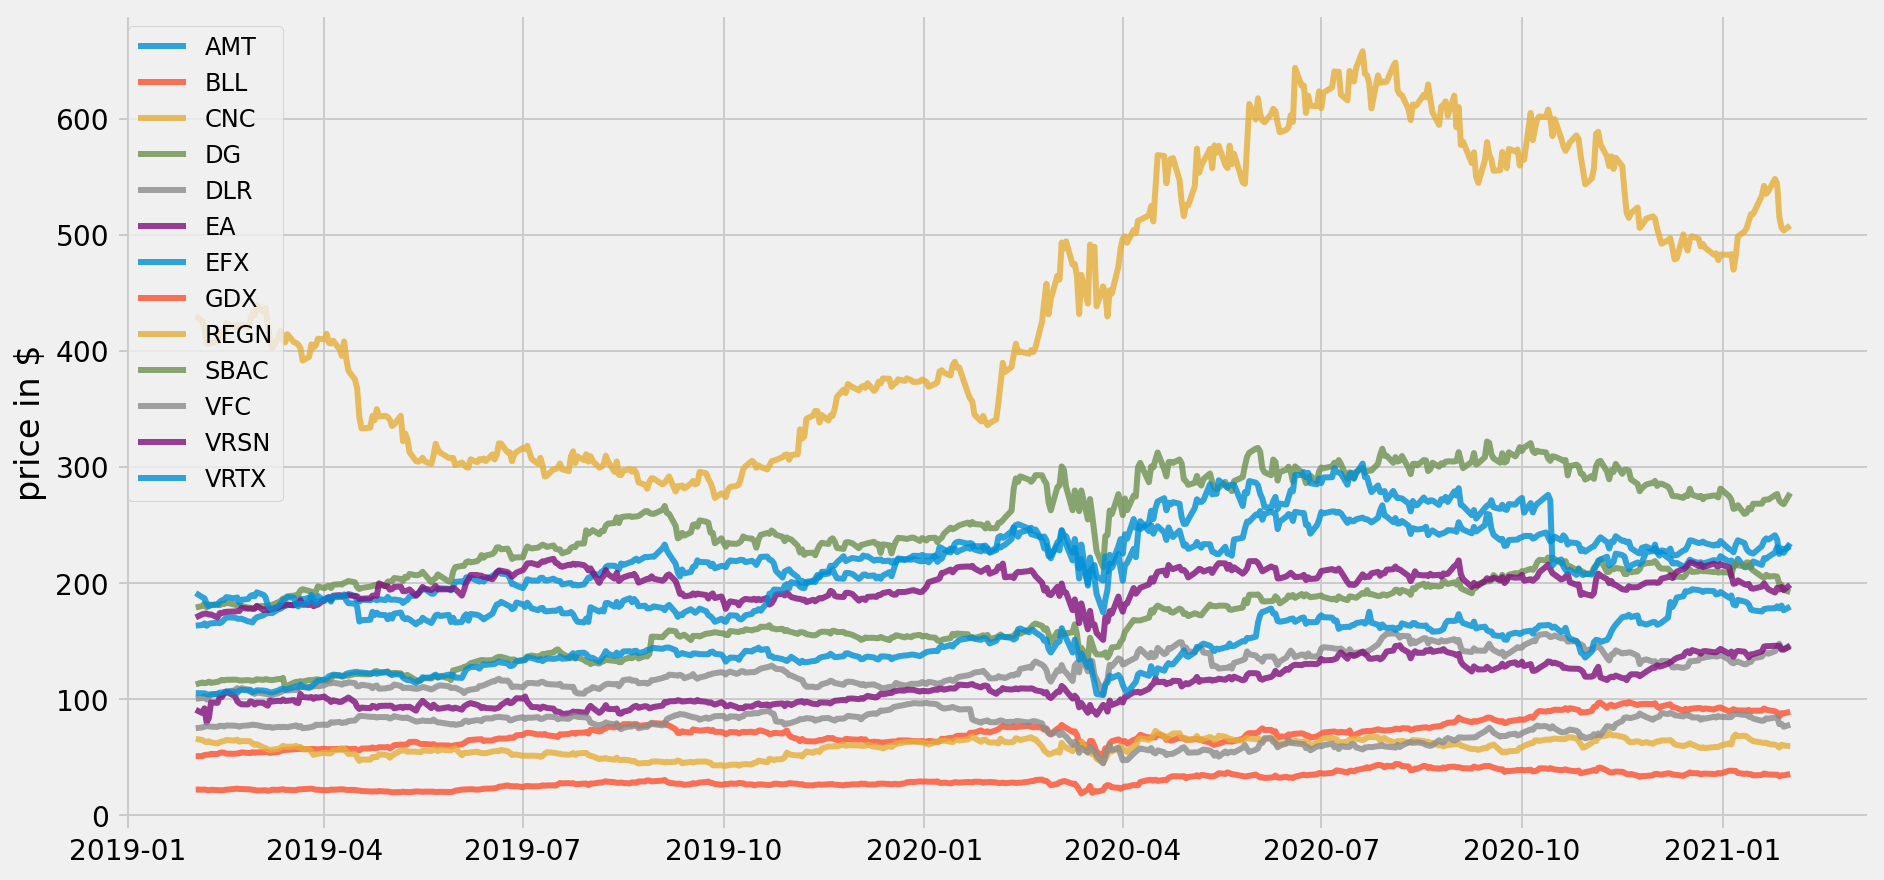

In [6]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, '2 years daily returns')

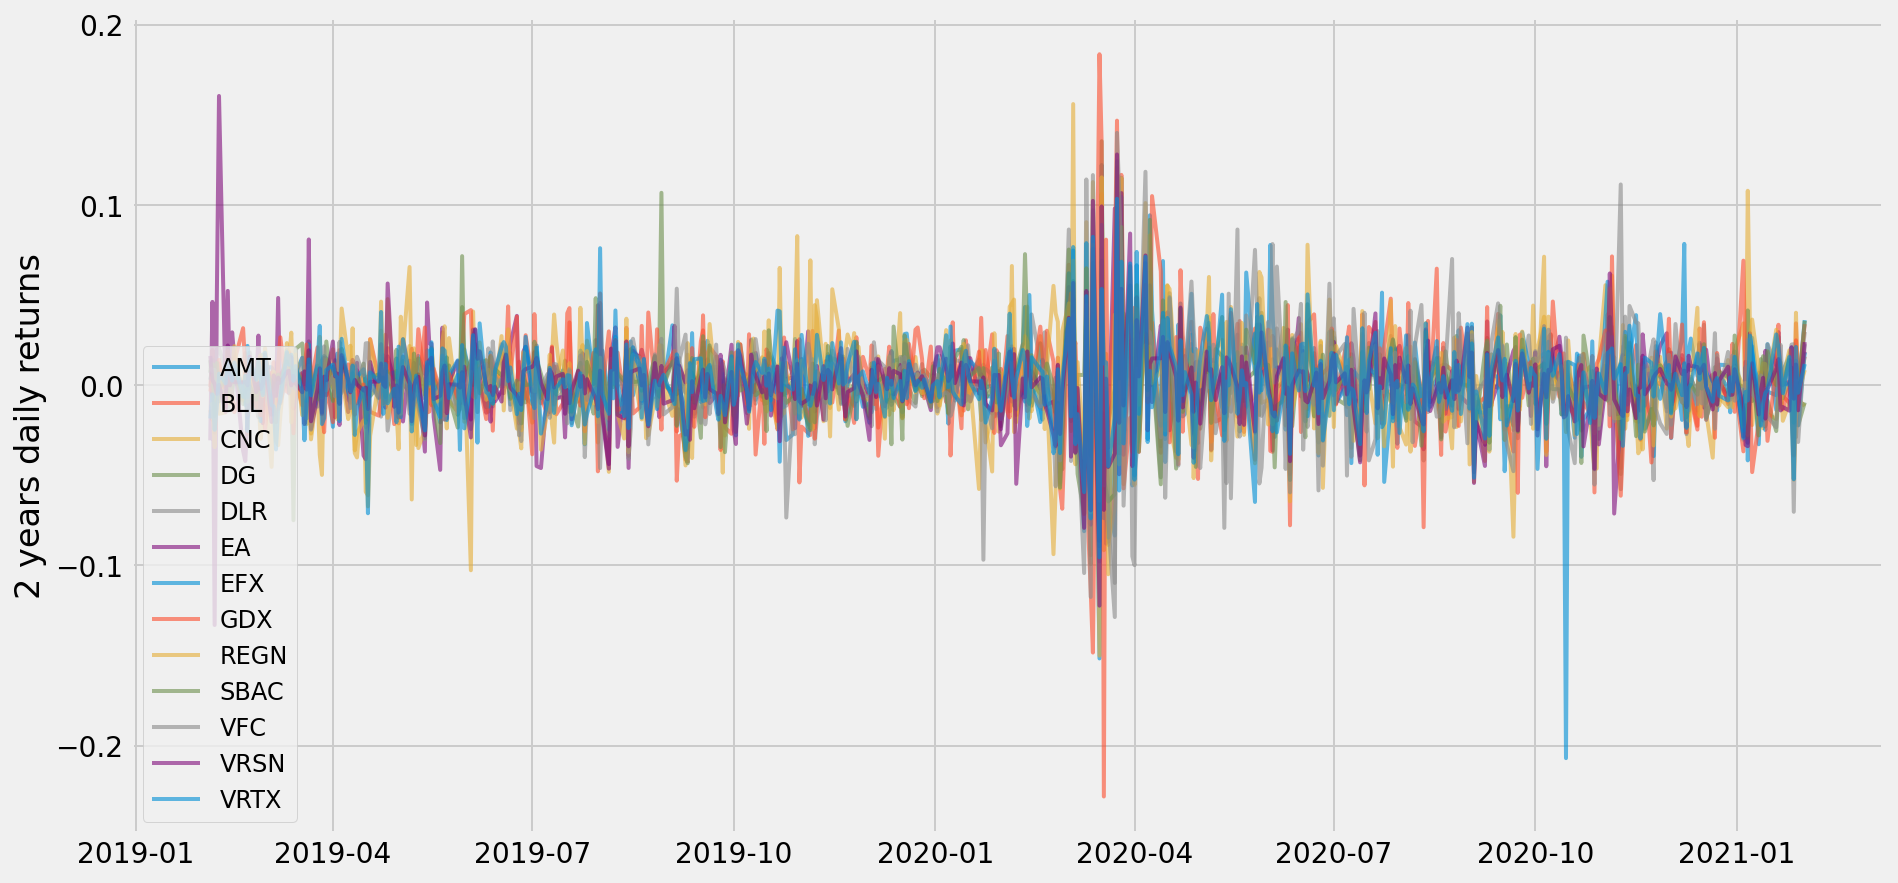

In [7]:
returns = (table - table.shift(1)) / table.shift(1)
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=2, alpha=100,label=c)
plt.legend(loc='lower left', fontsize=12)
plt.ylabel('2 years daily returns')

Text(0, 0.5, 'test data daily returns')

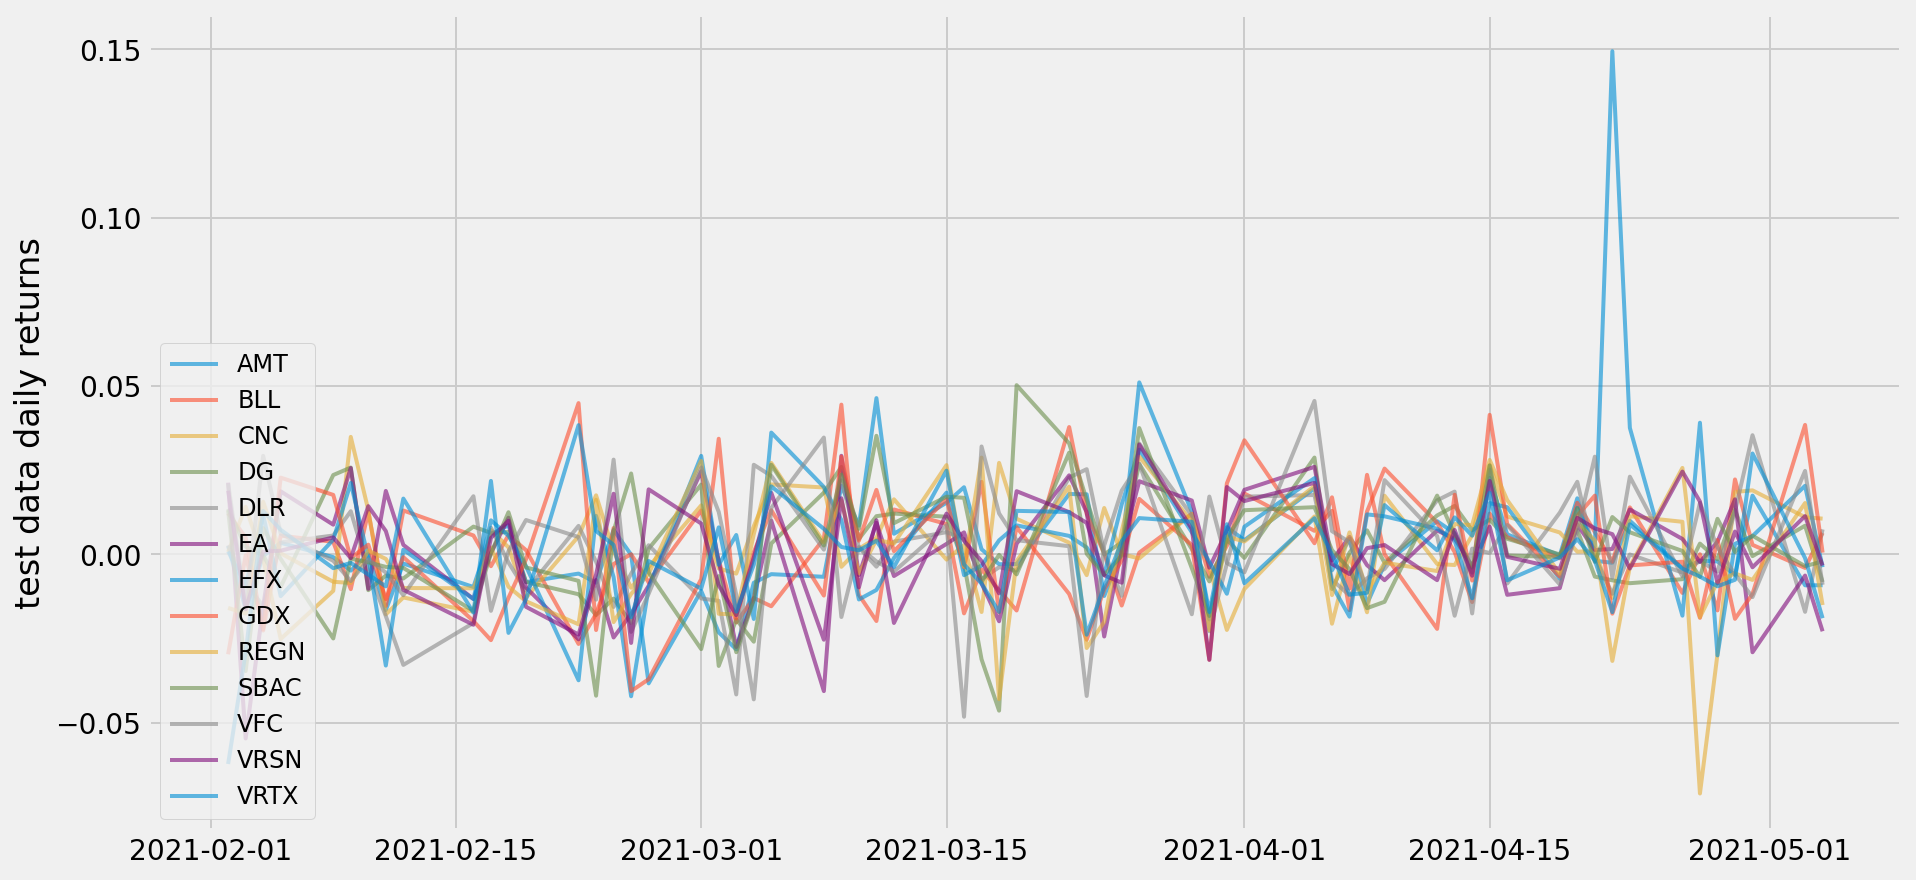

In [8]:
test_returns = (test - test.shift(1)) / test.shift(1)
plt.figure(figsize=(14, 7))
for c in test_returns.columns.values:
    plt.plot(test_returns.index, test_returns[c], lw=2, alpha=100,label=c)
plt.legend(loc='lower left', fontsize=12)
plt.ylabel('test data daily returns')

In [9]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [10]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0025

returns_test = test.pct_change()
mean_returns_test = returns_test.mean()
cov_matrix_test = returns_test.cov()

In [11]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.05,0.15)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [12]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.05,0.15)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [13]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.05,0.15) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [14]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print( "-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    print( "-"*80)
    print( "Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print( "-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.22


            AMT   BLL  CNC    DG  DLR     EA    EFX   GDX  REGN  SBAC  VFC  \
allocation  5.0  8.78  5.0  15.0  5.0  10.28  10.95  15.0   5.0   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.25
Annualised Volatility: 0.22


            AMT  BLL  CNC    DG   DLR     EA   EFX    GDX  REGN  SBAC  VFC  \
allocation  5.0  5.0  5.0  15.0  6.96  11.66  8.76  13.13  9.49   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AMT : annuaised return 0.24 , annualised volatility: 0.34
BLL : annuaised return 0.33 , annualised volatility:

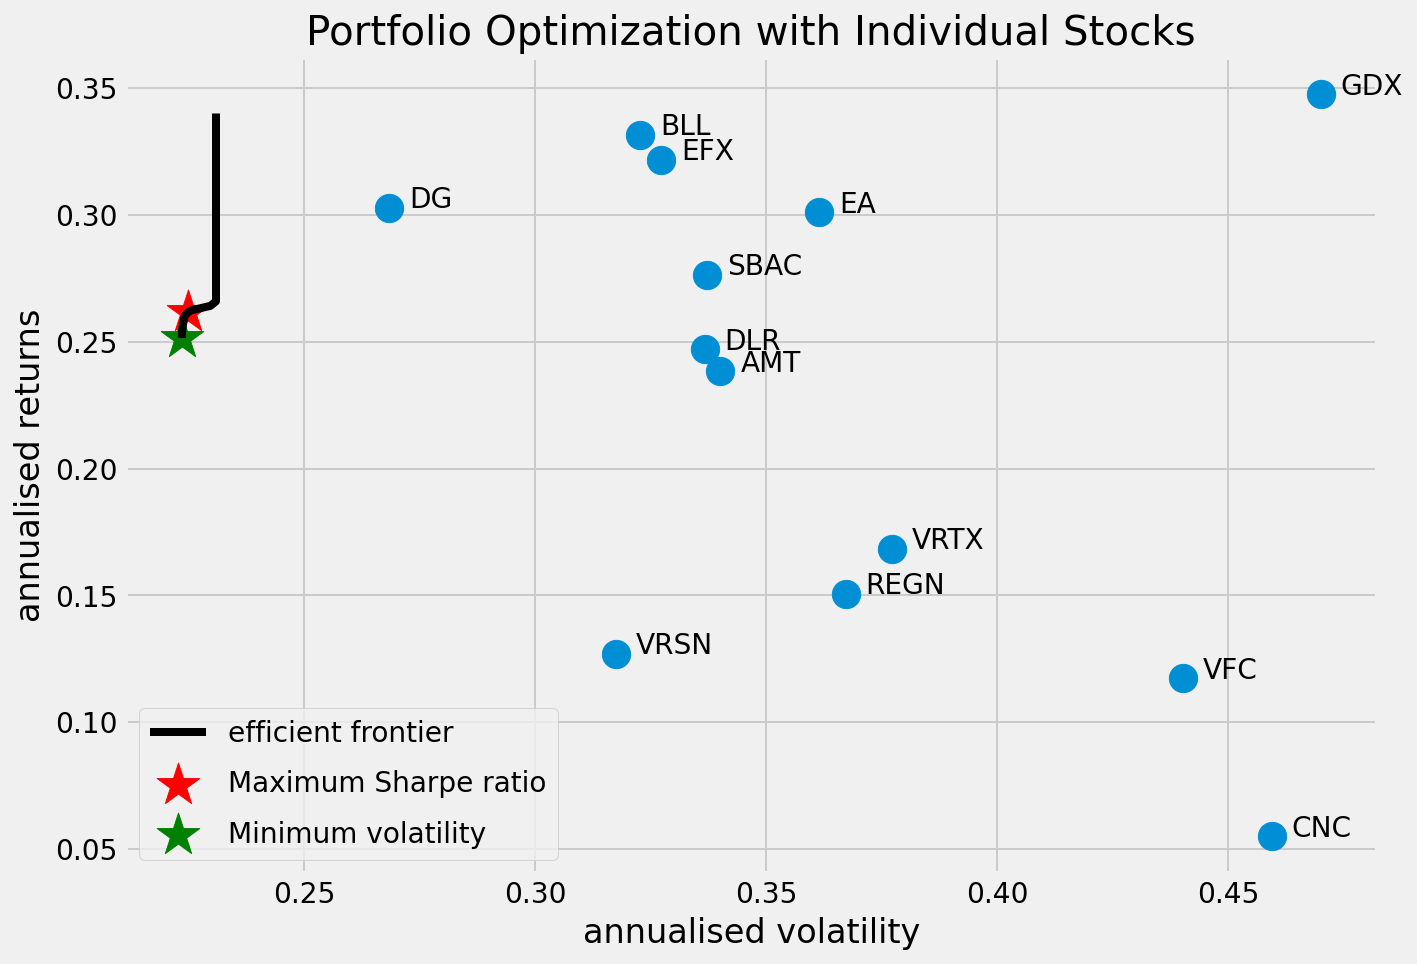

In [15]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [16]:
#paramethers for the last 3 months

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return in the test 3 months: 0.28
Annualised Volatility in the 3 months test period: 0.14


            AMT   BLL  CNC    DG  DLR     EA    EFX   GDX  REGN  SBAC  VFC  \
allocation  5.0  8.78  5.0  15.0  5.0  10.28  10.95  15.0   5.0   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
-------------------------------------------------------------------------------- 
 -------------------------------------------------------------------------------- 
 -------------------------------------------------------------------------------- 

Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.15


            AMT  BLL  CNC    DG   DLR     EA   EFX    GDX  REGN  SBAC  VFC  \
allocation  5.0  5.0  5.0  15.0  6.96  11.66  8.76  13.13  9.49   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
---------------

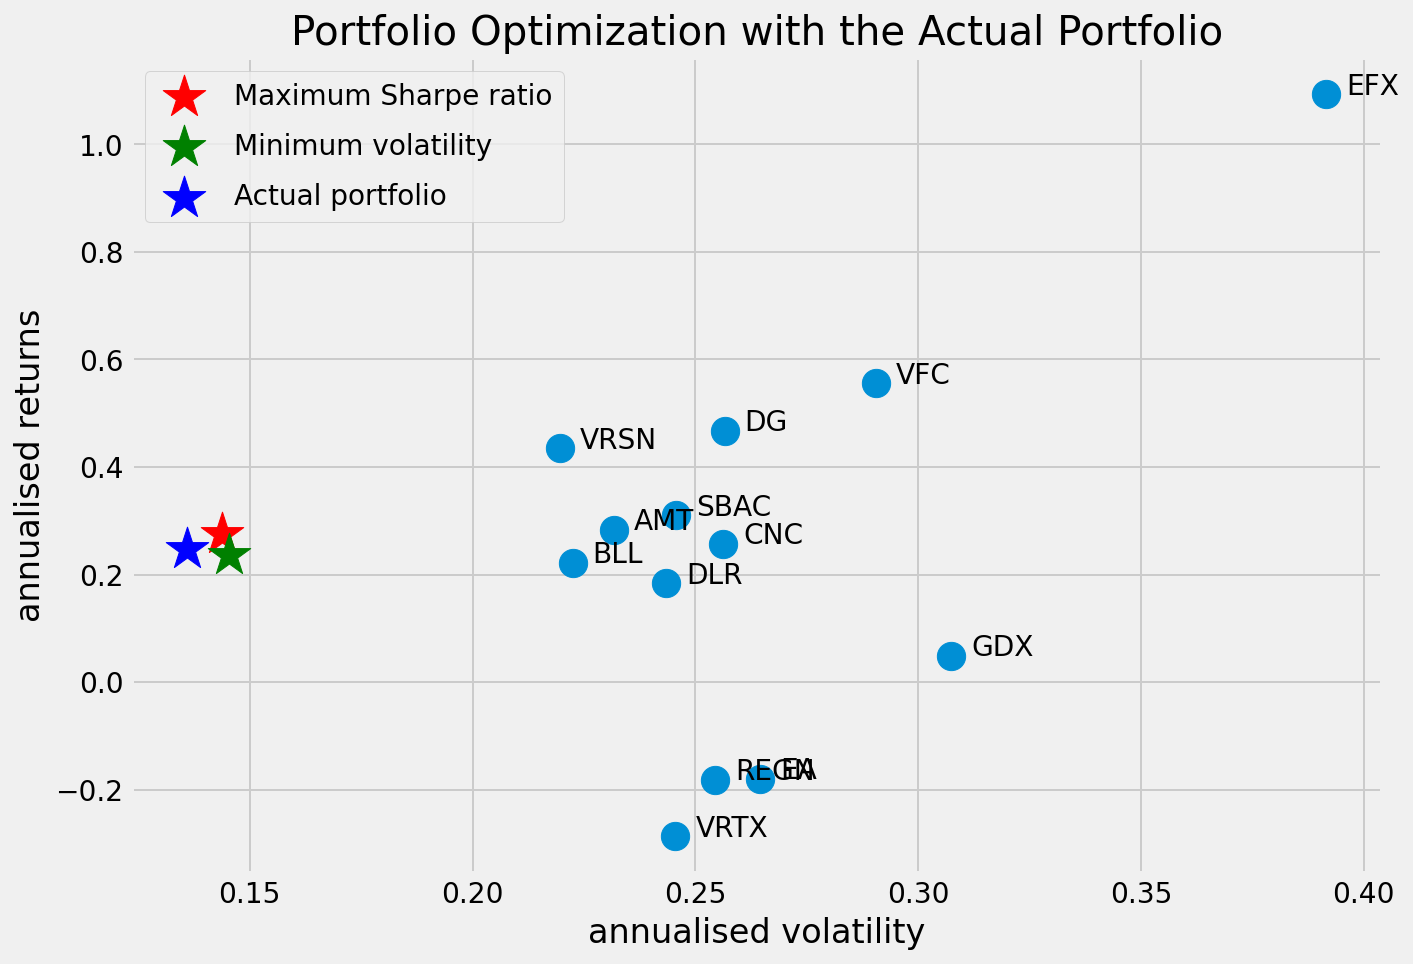

In [17]:
def show_the_results_after_3_months(mean_returns, cov_matrix, risk_free_rate,mean_returns_test, cov_matrix_test):    
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    std_sharp_test, ret_sharp_test = portfolio_annualised_performance(max_sharpe['x'], mean_returns_test, cov_matrix_test)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    print( "-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return in the test 3 months:", round(ret_sharp_test,2))
    print( "Annualised Volatility in the 3 months test period:", round(std_sharp_test,2))
    print( "\n")
    print(max_sharpe_allocation)

    
    min_vol = min_variance(mean_returns, cov_matrix)
    std_min_test, ret_min_test = portfolio_annualised_performance(min_vol['x'], mean_returns_test, cov_matrix_test)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=test.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(ret_min_test,2))
    print( "Annualised Volatility:", round(std_min_test,2))
    print( "\n")
    print(min_vol_allocation)
    
    
    std_actual, ret_actual = portfolio_annualised_performance(np.array([1/13]*13), mean_returns_test, cov_matrix_test)
    actual_allocation = pd.DataFrame(np.array([1/13]*13),index=test.columns,columns=['allocation'])
    actual_allocation['allocation'] =[round(i*100,2)for i in actual_allocation['allocation']]
    actual_allocation = actual_allocation.T
    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    print( "Actual Portfolio Allocation\n")
    print(actual_allocation)
    print( "\n")
    print( "Annualised Return:", round(ret_actual,2))
    print( "Annualised Volatility:", round(std_actual,2))
    
    an_vol = np.std(returns_test) * np.sqrt(252)
    an_rt = mean_returns_test * 252

    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    
    for i, txt in enumerate(test.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print( "-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(test.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(std_sharp_test,ret_sharp_test,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(std_min_test,ret_min_test,marker='*',color='g',s=500, label='Minimum volatility')
    ax.scatter(std_actual,ret_actual,marker='*',color='b',s=500, label='Actual portfolio')
    
    
    ax.set_title('Portfolio Optimization with the Actual Portfolio')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
show_the_results_after_3_months(mean_returns, cov_matrix, risk_free_rate,mean_returns_test, cov_matrix_test)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return in the test 3 months: 0.28
Annualised Volatility in the 3 months test period: 0.14


            AMT   BLL  CNC    DG  DLR     EA    EFX   GDX  REGN  SBAC  VFC  \
allocation  5.0  8.78  5.0  15.0  5.0  10.28  10.95  15.0   5.0   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
-------------------------------------------------------------------------------- 
 -------------------------------------------------------------------------------- 
 -------------------------------------------------------------------------------- 

Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.15


            AMT  BLL  CNC    DG   DLR     EA   EFX    GDX  REGN  SBAC  VFC  \
allocation  5.0  5.0  5.0  15.0  6.96  11.66  8.76  13.13  9.49   5.0  5.0   

            VRSN  VRTX  
allocation   5.0   5.0  
---------------

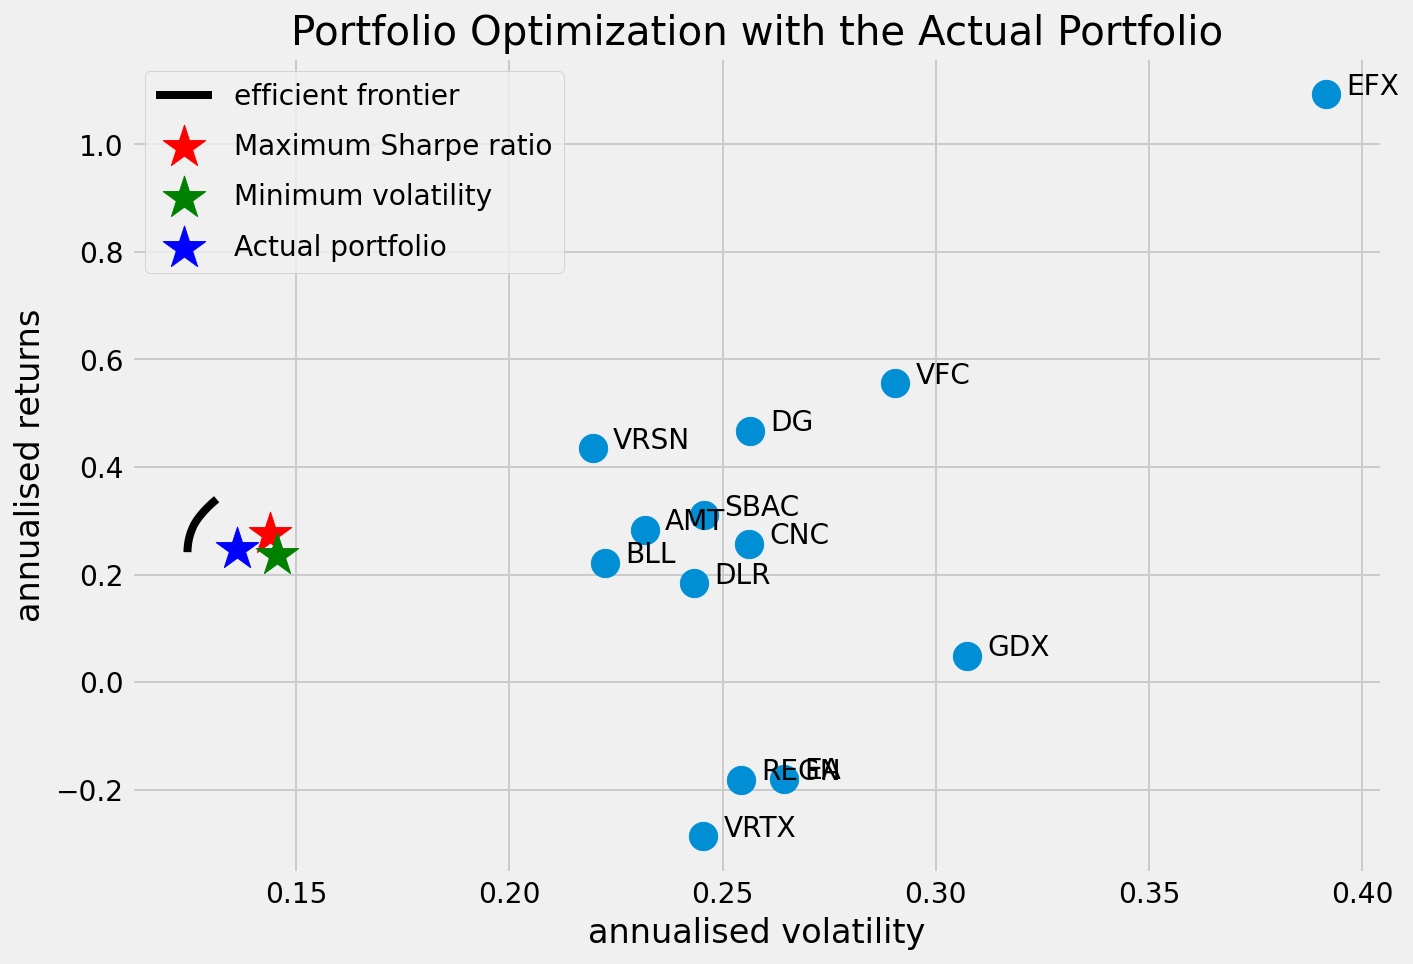

In [18]:
def show_the_results_after_3_months(mean_returns, cov_matrix, risk_free_rate,mean_returns_test, cov_matrix_test):
    
    
    
    
    max_sharpe1 = max_sharpe_ratio(mean_returns_test, cov_matrix_test, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe1['x'], mean_returns_test, cov_matrix_test)
    max_sharpe_allocation1 = pd.DataFrame(max_sharpe1.x,index=test.columns,columns=['allocation'])
    max_sharpe_allocation1.allocation = [round(i*100,2)for i in max_sharpe_allocation1.allocation]
    max_sharpe_allocation1 = max_sharpe_allocation1.T
    max_sharpe_allocation1

    min_vol1 = min_variance(mean_returns_test, cov_matrix_test)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol1['x'], mean_returns_test, cov_matrix_test)
    min_vol_allocation1 = pd.DataFrame(min_vol1.x,index=test.columns,columns=['allocation'])
    min_vol_allocation1.allocation = [round(i*100,2)for i in min_vol_allocation1.allocation]
    min_vol_allocation1 = min_vol_allocation1.T
    
    
    
    
    
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    std_sharp_test, ret_sharp_test = portfolio_annualised_performance(max_sharpe['x'], mean_returns_test, cov_matrix_test)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    print( "-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return in the test 3 months:", round(ret_sharp_test,2))
    print( "Annualised Volatility in the 3 months test period:", round(std_sharp_test,2))
    print( "\n")
    print(max_sharpe_allocation)

    
    min_vol = min_variance(mean_returns, cov_matrix)
    std_min_test, ret_min_test = portfolio_annualised_performance(min_vol['x'], mean_returns_test, cov_matrix_test)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=test.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(ret_min_test,2))
    print( "Annualised Volatility:", round(std_min_test,2))
    print( "\n")
    print(min_vol_allocation)
    
    
    std_actual, ret_actual = portfolio_annualised_performance(np.array([1/13]*13), mean_returns_test, cov_matrix_test)
    actual_allocation = pd.DataFrame(np.array([1/13]*13),index=test.columns,columns=['allocation'])
    actual_allocation['allocation'] =[round(i*100,2)for i in actual_allocation['allocation']]
    actual_allocation = actual_allocation.T
    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    print( "Actual Portfolio Allocation\n")
    print(actual_allocation)
    print( "\n")
    print( "Annualised Return:", round(ret_actual,2))
    print( "Annualised Volatility:", round(std_actual,2))
    
    an_vol = np.std(returns_test) * np.sqrt(252)
    an_rt = mean_returns_test * 252

    print( "-"*80, "\n","-"*80, "\n","-"*80, "\n")
    
    for i, txt in enumerate(test.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print( "-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(test.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(std_sharp_test,ret_sharp_test,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(std_min_test,ret_min_test,marker='*',color='g',s=500, label='Minimum volatility')
    ax.scatter(std_actual,ret_actual,marker='*',color='b',s=500, label='Actual portfolio')
    
    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns_test, cov_matrix_test, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-', color='black', label='efficient frontier')
    
    ax.set_title('Portfolio Optimization with the Actual Portfolio')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
show_the_results_after_3_months(mean_returns, cov_matrix, risk_free_rate,mean_returns_test, cov_matrix_test)